In [26]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np 
import os
from scipy.stats import gaussian_kde

import utils

In [83]:
expert_filepath = '../../data/trajectories/ngsim_1.h5'
expert = utils.load_data(
    expert_filepath, 
    min_length=250, 
    normalize_data=True, 
)
expert_actions = utils.load_data(
    expert_filepath, 
    min_length=250, 
    normalize_data=False,
)
expert['actions'] = 

In [ ]:
dirs = [
    '../../data/experiments/gail/imitate/validation/',
    '../../data/experiments/infogail/imitate/validation/',
    '../../data/experiments/hgail/imitate/validation/',
    '../../data/experiments/gail-recurrent/imitate/validation/'
]
model_labels = [
    'gail',
    'infogail',
    'hgail',
    'recurrent gail'
]
model_trajs = []
ngsim_labels = None
for d, model_label in zip(dirs, model_labels):
    trajs, ngsim_labels = utils.load_trajs_labels(d)
    model_trajs.append(trajs)
    model_labels.append(ngsim_labels)

In [84]:
expert_values = dict()
expert_values['0750am-0805am'] = dict()
expert_bounds = dict()
expert_bounds['0750am-0805am'] = dict()
expert_values['0750am-0805am']['lon_accel'] = gaussian_kde(expert['actions'][:,0])
expert_bounds['0750am-0805am']['lon_accel'] = (np.min(expert['actions'][:,0]), np.max(expert['actions'][:,0]))
expert_values['0750am-0805am']['lat_accel'] = gaussian_kde(expert['actions'][:,1])
expert_bounds['0750am-0805am']['lat_accel'] = (np.min(expert['actions'][:,1]), np.max(expert['actions'][:,1]))
expert_values['0750am-0805am']['velocity'] = gaussian_kde(expert['observations'][:,2])
expert_bounds['0750am-0805am']['velocity'] = (np.min(expert['observations'][:,2]), np.max(expert['observations'][:,2]))
expert_values['0750am-0805am']['jerk'] = gaussian_kde(expert['observations'][:,9])
expert_bounds['0750am-0805am']['jerk'] = (np.min(expert['observations'][:,9]), np.max(expert['observations'][:,9]))
expert_values['0750am-0805am']['ttc'] = gaussian_kde(expert['observations'][:,16])
expert_bounds['0750am-0805am']['ttc'] = (np.min(expert['observations'][:,16]), np.max(expert['observations'][:,16]))

In [61]:
def compute_kl(ref, comp, x):
    logp = ref.logpdf(x)
    p = np.exp(logp)
    logq = comp.logpdf(x)
    return - np.sum(p * (logq - logp))

In [62]:
def compute_emergent_divergence(trajs, labels, bounds, expert, nbins=100):
    # collect values
    emergent = dict()
    for (timeperiod, l) in zip(trajs, labels):
        emergent[l] = dict()
        emergent[l]['lon_accel'] = np.concatenate([traj['actions'][:,0] for traj in timeperiod])
        emergent[l]['lat_accel'] = np.concatenate([traj['actions'][:,1] for traj in timeperiod])
        emergent[l]['velocity'] = np.concatenate([traj['observations'][:,2] for traj in timeperiod])
        emergent[l]['jerk'] = np.concatenate([traj['observations'][:,9] for traj in timeperiod])
        emergent[l]['ttc'] = np.concatenate([traj['observations'][:,16] for traj in timeperiod])
        
    # compute divergences
    divergences = dict()
    for l, l_values in emergent.items():
        
        if l not in expert.keys():
            continue
            
        divergences[l] = dict()
        for k, values in l_values.items():
            comp = gaussian_kde(values)
            low = min(bounds[l][k][0], np.min(values))
            high = max(bounds[l][k][1], np.max(values))
            x = np.linspace(low, high, nbins)
            divergences[l][k] = compute_kl(expert[l][k], comp, x)
            
    return divergences

In [85]:
model_divs = []
for trajs in model_trajs:
    divs = compute_emergent_divergence(trajs, ngsim_labels, expert_bounds, expert_values)
    model_divs.append(divs)

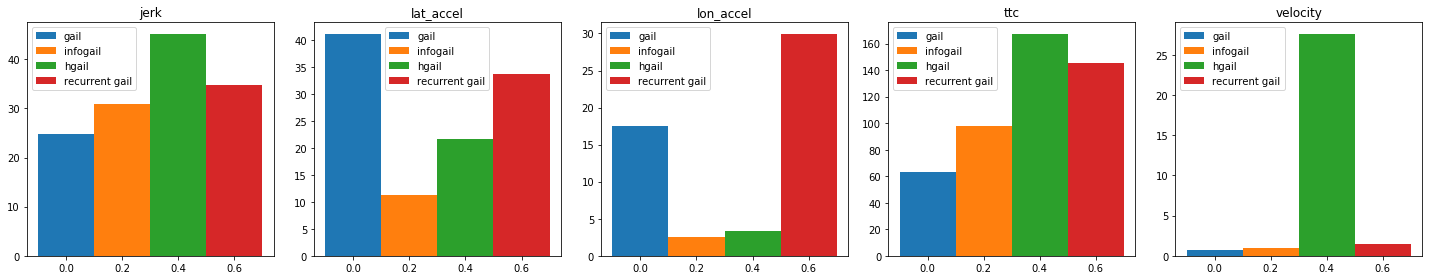

In [86]:
plt.figure(figsize=(20,4))
attr_width = .2
for i, divs in enumerate(model_divs):
    
    for (timeperiod, timeperiod_divs) in divs.items():
        attr_keys = sorted(timeperiod_divs.keys())
        
        for j, attr in enumerate(attr_keys):
            plt.subplot(1,5,j+1)
            plt.title(attr)
            div = timeperiod_divs[attr]
            plt.bar(i*attr_width, div, width=model_width, label=model_labels[i])
            if i == len(model_divs) - 1:
                plt.legend()

plt.tight_layout()

<Container object of 100 artists>

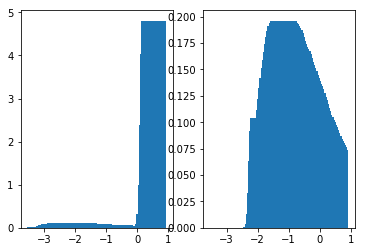

In [87]:
low = expert_bounds['0750am-0805am']['ttc'][0]
high = expert_bounds['0750am-0805am']['ttc'][1]
x = np.linspace(low, high, 100)
ref = expert_values['0750am-0805am']['ttc']
plt.subplot(1,2,1)
plt.bar(x, ref.pdf(x))
plt.subplot(1,2,2)
vals = np.concatenate([traj['observations'][:,16] for traj in model_trajs[2][0]])
comp = gaussian_kde(vals)
plt.bar(x, comp.pdf(x))
